In [94]:
# Standard imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, r2_score
import seaborn as sns

import sklearn.pipeline
import sklearn.grid_search
import sklearn

%matplotlib inline

In [95]:
import time
t0 = time.time()

In [96]:
df = pd.read_csv('/Users/cvh/data/mcnulty_data/loan.csv')
df_copy = df.copy()

In [99]:
df_len = str(len(df))

## Feature Engineering -- Derek

In [100]:
import pandas as pd
import numpy as np
import re

import datetime

# This appends a lot of additional columns to the dataframe
# derek_features is a list of the new ones that are okay to throw in the model
# sub_grade_num is an integer 1 (grade A1) to 41 (grade G5), increasing with loan risk
# grade_num is the same, just less granular; 1 (A) to 7 (G)
# term_num is the length of the loan in months
# is_joint is a binary; 1 if the loan had a cosigner
# emp_length_num is the length of employment
# 0 means < 1 year and 10 means >= 10, 1-9 are integer years
# 'desc_length' is the length of the lendee's description of the loan
# purpose_in_title is whether the purpose of that loan is in the text of the title
# count_purposes_in_title is the total number of times any of the loan purpose options
# is listed in the title
# borrower_additions in desc is how many times the borrower added text to the description
# upperfraction_title is the fraction of alphabetical characters in the title
# which are upper-case 
# pre_loan_credit_hist_length is the length in years between the loan issue and the 
# borrower's earliest line of credit
# 'desc_count_$' is the number of times '$' occurs in the loan description;
# it's meant to get at how much detail they went into about their expenses, etc. 


def getyear(datestr):
    if type(datestr) == str:
        return int(datestr[-4:])
    else:
        return 0
        
def getmonth(datestr):
    if type(datestr) == str:
        months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep',
                  'Oct','Nov', 'Dec']
        return months.index(datestr[:3]) + 1
    else:
        return 0

def getdate(datestr):
    if type(datestr) == str:
        return datetime.date(getyear(datestr), getmonth(datestr), 1)
    else:
        return 0

def getemp(time_input):
    if type(time_input) == str:
        if time_input == 'n/a':
            return 0
        else:
            num = int(re.sub("[^0-9]", "", time_input))
            if '<' in time_input:
                num = num - 1
        return int(num)
    else:
        return time_input

def getterm(term_input):
    out = 36
    if type(term_input) == str:
        if '60' in term_input:
            out = 60
    return out

def checklen(entry):
    if type(entry) == str:
        return len(entry)
    else:
        return 0

def getgrade(grade):
    if type(grade) == str:
        letters = 'ABCDEFGHIJK'
        A = letters.find(grade[0])*5
        if len(grade) > 1:
            B = int(grade[1:])
        else:
            B = 0
            A = A/5 + 1
        return int(A + B)
    else:
        return int(grade)

def nonegative(value):
    if value < 0:
        return 0
    else:
        return value

def makebinaries(dataframe, column_name, max_values = False):
    names = dataframe[column_name].value_counts().index
    newcolnames, n = [], len(names)
    if max_values > 0 and max_values < n:
        names = names[:max_values]
    for name in names:
        newcolname = column_name + '_' + name
        dataframe[newcolname] = (dataframe[column_name] == name) + 0
        newcolnames.append(newcolname)
    if max_values > 0 and max_values < n:
        newcolname = column_name + '_IS_OTHER_VALUE'
        dataframe[newcolname] = 1 - (dataframe[column_name].isin(names))
        newcolnames.append(newcolname)
    return newcolnames

date_column_names = ['earliest_cr_line', 'issue_d','last_pymnt_d',
                     'next_pymnt_d', 'last_credit_pull_d']
date_column_names_pre_loan = ['earliest_cr_line', 'issue_d']
derek_features = []
for name in date_column_names:
    nm, ny, nd = name+'_month', name+'_year', name+'_datetime'
    df[nm] = df[name].apply(getmonth,1)
    df[ny] = df[name].apply(getyear,1)
    df[nd] = df[name].apply(getdate,1)
    if name in date_column_names_pre_loan:
        derek_features.extend([nm, ny])
        
derek_features.extend(makebinaries(df, 'home_ownership', max_values = 3))
derek_features.extend(makebinaries(df, 'purpose'))

df['emp_length_num'] = df['emp_length'].apply(getemp,1)
df['is_joint'] = (df['application_type'] == 'JOINT') + 0
df['grade_num'] = df['grade'].apply(getgrade,1)
df['sub_grade_num'] = df['sub_grade'].apply(getgrade,1)
df['term_num'] = df['term'].apply(getterm,1)
df['months_loan_to_last_pay'] = (df['last_pymnt_d_year'] - df['issue_d_year']) * 12 + (df['last_pymnt_d_month']
                                                                                      - df['issue_d_month'])
df['months_loan_to_last_pay'] = df['months_loan_to_last_pay'].apply(nonegative, 1)
df['desc_length'] = df['desc'].apply(checklen,1)
df['title_length'] = df['desc'].apply(checklen,1)



derek_features.extend(['emp_length_num', 'is_joint','term_num',
                     'desc_length', 'title_length', 'grade_num', 'sub_grade_num'])
                    

    
def formatfix(mystring):
    if type(mystring) == str:
        mystring1 = '_'.join(mystring.split())
        mystring1 = mystring1.lower()
        mystring1 = mystring1.replace(' ','_') 
        return ''.join(c for c in mystring1 if c not in '!"#$%&\'()*+,-./:;=?@[\\]^`{|}~')
    else:
        return 0
        
def commondict(dataframe, colname, normalize = False):
    values = list(dataframe[colname].value_counts().index)
    valuecounts = list(df[colname].value_counts())
    if normalize == True:
        n = sum(valuecounts)
    else:
        n = 1
    d = {}
    for i in range(len(valuecounts)):
        d[values[i]] = valuecounts[i]/n
    return d            

def howoften(dataframe, col, in_suffix = '', out_suffix = '_freq'):
    colname = col + in_suffix
    d = commondict(dataframe, colname)
    import pandas as pd
    def getfreq(value, d=d):
        if pd.isnull(value):
            return 0
        else:
            return d[value]
    dataframe[col + out_suffix] = dataframe[colname].apply(getfreq,1)

textcols = ['desc', 'title', 'purpose']
for col in textcols:
    df[col + '_formatted'] = df[col].apply(formatfix,1)
    howoften(df, col, in_suffix = '_formatted', out_suffix = '_freq')
    

unique_purposes = list(set(list(df.purpose_formatted)))    

def countin(value, mylist = unique_purposes):
    if type(value) == str:
        n = 0
        for entry in mylist:
            n = n + value.count(entry)
        return n
    else:
        return 0

def countborrower(value):
    if type(value) == str:
        return value.count('borrower_added')
    else:
        return 0

def upperfraction(message):
    if type(message) == str:
        upper = sum(1 for c in message if c.isupper())
        lower = sum(1 for c in message if c.islower())
        if (upper + lower) == 0:
            return 1
        else:
            return upper/(upper + lower)
    else:
        return 0
  
def p_t(row):
    if type(row['purpose_formatted']) == str and type(row['title_formatted']) == str:
        return int(row['purpose_formatted'] in row['title_formatted'])
    else:
        return 0

def p_d(row):
    if type(row['purpose_formatted']) == str and type(row['desc_formatted']) == str:
        return int(row['purpose_formatted'] in row['desc_formatted'])
    else:
        return 0
        
def countS(message):
    if type(message) == str:
        return message.count('$')
    else:
        return 0

df['desc_count_$'] = df['desc'].apply(countS,1)
df["purpose_in_desc"] = df.apply(p_d, axis=1)    
df["purpose_in_title"] = df.apply(p_t, axis=1)    
df['upperfraction_title'] =  df['title'].apply(upperfraction,1)
df['upperfraction_desc'] =  df['desc'].apply(upperfraction,1)
df['count_purposes_in_title'] = df['title_formatted'].apply(countin,1)
df['count_purposes_in_desc'] = df['desc_formatted'].apply(countin,1)
df['borrower_additions_in_desc'] = df['desc_formatted'].apply(countborrower,1)
df['pre_loan_credit_hist_length'] = df['issue_d_year'] - df['earliest_cr_line_year'] + 1/12*(df['issue_d_month']
                                                                                      - df['earliest_cr_line_month'])
df['pre_loan_credit_hist_length'] = df['pre_loan_credit_hist_length'].apply(nonegative, 1)

derek_features.extend(['purpose_in_title','purpose_in_desc','count_purposes_in_title','count_purposes_in_desc',
                     'borrower_additions_in_desc', 'pre_loan_credit_hist_length',
                     'upperfraction_title', 'upperfraction_desc', 'desc_count_$'])

old_features = ['annual_inc', 'dti', 'pub_rec']


## Feature Engineering -- Carl

In [101]:
cvh_features = []
def binary_profit(value):
    if value > 0:
        return 1
    else:
        return 0
# Nominal profit loss in dollars
df['profit_loss'] = df['total_pymnt'] - df['funded_amnt']
df['profit_loss_rate'] = df['profit_loss']/df['funded_amnt']

# 1 is profit, 0 is negative
df['binary_profit_loss'] = df['profit_loss'].apply(binary_profit)

# Total payment corrected for fees
df['tot_pymnt_less_fees'] = df['total_pymnt'].apply(lambda x: .99*x)

# Deal with NaNs in pub_rec.
df.pub_rec.replace(np.NaN, 0, inplace=True)


# Binary for whether loan has concluded. Use to filter rows.
def concluded(status):
    if status in ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid',
                             'Charged Off', 'Default',
                             'Does not meet the credit policy. Status:Charged Off']:
        return 1
    else:
        return 0
df['loan_concluded'] = df.loan_status.apply(concluded)





cvh_features.extend(['funded_amnt'])

## Feature Engineering -- Naoya

In [102]:
# make sure you have zip3_mean_incomes.csv for income by zip3 area code

def add_zip3_income_pop(df):
    '''Add average income and population for ZIP3 area'''
    zip3_incomes = pd.read_csv('zip3_mean_incomes.csv')
    zip3_incomes.set_index('zip_code', inplace=True)
    return df.join(zip3_incomes, on='zip_code', how='left')

df = add_zip3_income_pop(df)

def mths_since_credit_event(df):
    '''
    Transforms months since credit event
    No history = 1, 0 months ago = 0
    ''' 
    df.loc[:,'record'] = 1 - 1 / (1 + df['mths_since_last_record'])
    df.loc[:,'delinq'] = 1 - 1 / (1 + df['mths_since_last_delinq'])
    df.loc[:,'derog'] = 1 - 1 / (1 + df['mths_since_last_major_derog'])
    df['record'].replace([np.nan], 1, inplace=True)
    df['delinq'].replace([np.nan], 1, inplace=True)
    df['derog'].replace([np.nan], 1, inplace=True)
    return df
df = mths_since_credit_event(df)

naoya_fields = ['record', 'delinq', 'derog', 'zip3_mean_income']

## Combining Features

In [103]:
features_lists = [old_features, derek_features, cvh_features, naoya_fields]
all_good_features = []
for feature_list in features_lists:
    all_good_features.extend(feature_list)

# Adjust for interest or not

In [104]:
Interest_Adjust = True
Adjustment_Rate = 1.017
# set this here to adjust interest
# 1.017 is the inflation average over the period of the loans
# 1.054 is the minimum loan interest rate
# 1.035 is the mean of the two

def timecost(term_months, opportunity_interest_rate = Adjustment_Rate):
    return opportunity_interest_rate**(term_months/24)
    
df['time_cost_factor'] = df['term_num'].apply(timecost,1)
df['funded_amnt_adj'] = df.funded_amnt * df.time_cost_factor
df['profit_loss_adj'] = df.total_pymnt - df.funded_amnt_adj
df['profit_loss_rate_adj'] = df.profit_loss_adj/df.funded_amnt_adj
df['binary_profit_loss_adj'] = (df['profit_loss_rate_adj'] > 0) + 0

if Interest_Adjust == True:
    suffix = '_adj'
else:
    suffix = ''
    
cvh_features[0] = 'funded_amnt' + suffix

In [428]:
# Derek's ROI calculator
def annual_return_row(row, baseline_interest = 1.017):
    return ((row['total_pymnt']/row['funded_amnt']) ** (24 / row['term_num']) / baseline_interest) - 1

df["annualized_return_rate"] = df.apply(annual_return_row, axis=1)

## Checking for dupes and filtering

In [105]:
good_uniques = list(set(all_good_features))
if len(all_good_features) > len(good_uniques):
    print('WE GOT A PROBLEM')


In [432]:

df_concluded = df.copy()
df_concluded = df_concluded[df_concluded['loan_concluded'] == 1]
data = df_concluded[all_good_features]
data['binary_profit_loss' + suffix] = df_concluded['binary_profit_loss' + suffix]
data['profit_loss'  + suffix] = df_concluded['profit_loss' + suffix]
data['profit_loss_rate' + suffix] = df_concluded['profit_loss_rate' + suffix]
data['funded_amnt'  + suffix] = df_concluded['funded_amnt' + suffix]
data["annualized_return_rate"] = df["annualized_return_rate"]

L = len(data)
data.dropna(inplace = True)
D = L - len(data)
print(str(D) + ' of ' + str(L) + ' rows dropped due to NaNs')

/Users/cvh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cvh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cvh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

115 of 256939 rows dropped due to NaNs


/Users/cvh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyboardInterrupt: 

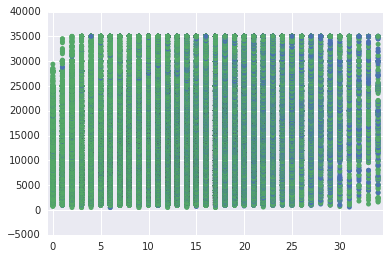

In [58]:
sns.swarmplot(x="sub_grade_num", y="loan_amnt", hue="binary_profit_loss", data=df_concluded);

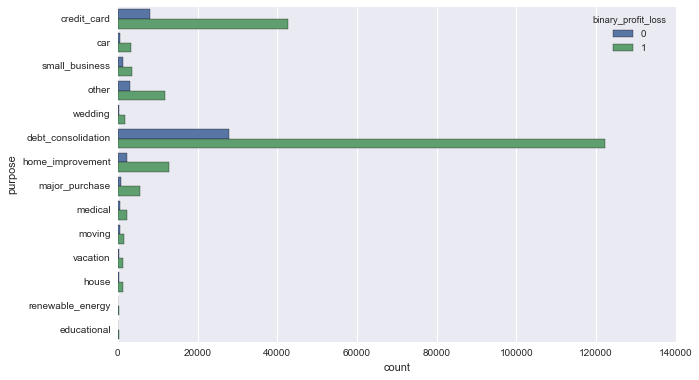

In [37]:
plt.figure(figsize=(10,6))
sns.countplot(y="purpose", hue="binary_profit_loss", data=df_concluded, orient='h');

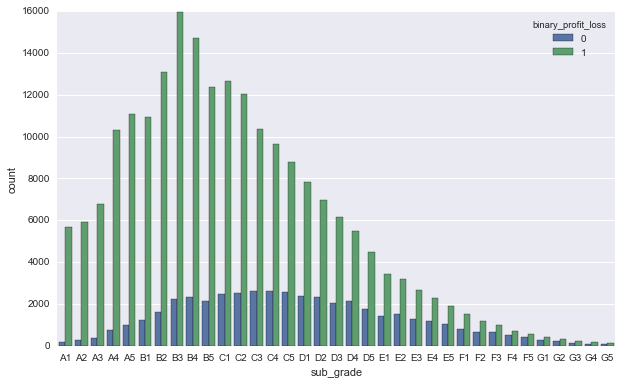

In [38]:
plt.figure(figsize=(10,6))

sns.countplot(df_concluded.sub_grade.sort_values(), hue="binary_profit_loss", data=df_concluded);

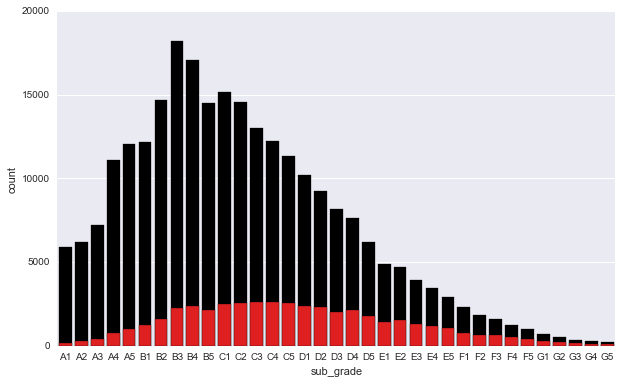

In [435]:
plt.figure(figsize=(10,6))

sns.countplot(df_concluded.sub_grade.sort_values(), data=df_concluded, color='black')
sns.countplot(df_concluded.sub_grade[df_concluded.binary_profit_loss == 0].sort_values(), color='red');

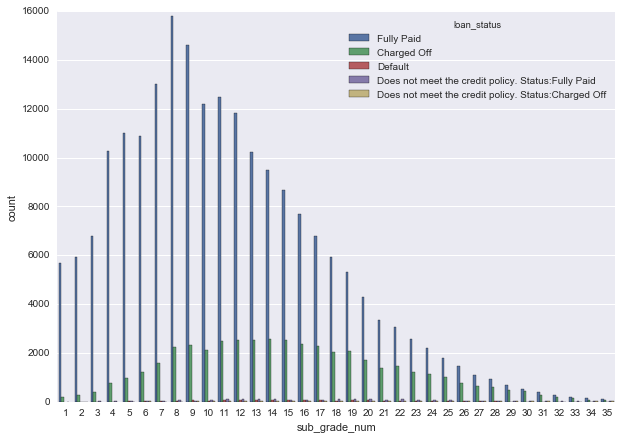

In [40]:
plt.figure(figsize=(15,7))
sns.countplot(x="sub_grade_num", hue="loan_status", data=df_concluded);

# Modelling

In [431]:
# Use this to subset data for testing, use data_sub = data for final model
data_sub = data

In [150]:
data_sub_len = str(len(data_sub))

In [151]:
data_sub.head(1)

,annual_inc,dti,pub_rec,earliest_cr_line_month,earliest_cr_line_year,issue_d_month,issue_d_year,home_ownership_MORTGAGE,home_ownership_RENT,home_ownership_OWN,...,desc_count_$,funded_amnt,record,delinq,derog,zip3_mean_income,binary_profit_loss_adj,profit_loss_adj,profit_loss_rate_adj,funded_amnt_adj
0,24000.0,27.65,0.0,1,1985,12,2011,0,1,0,...,0,5000.0,1.0,1.0,1.0,56220.005926,1,776.071414,0.15262,5085.0


In [152]:
y = data_sub['binary_profit_loss' + suffix]
profit_loss = data_sub['profit_loss' + suffix]
funded_amnt = data_sub['funded_amnt' + suffix]
profit_loss_rate = data_sub['profit_loss_rate' + suffix]


# data_sub_X = data_sub.drop('binary_profit_loss',axis=1)
# data_sub_X = data_sub_X.drop('profit_loss',axis=1)


In [153]:
# Drop earlies_cr_line_month, earliest_cr_line_year, grade_num
all_good_features.remove('earliest_cr_line_month')
all_good_features.remove('earliest_cr_line_year')
all_good_features.remove('grade_num')

ValueError: list.remove(x): x not in list

In [154]:
print sorted(list(data_sub[all_good_features].columns))

['annual_inc', 'borrower_additions_in_desc', 'count_purposes_in_desc', 'count_purposes_in_title', 'delinq', 'derog', 'desc_count_$', 'desc_length', 'dti', 'emp_length_num', 'funded_amnt', 'home_ownership_IS_OTHER_VALUE', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'is_joint', 'issue_d_month', 'issue_d_year', 'pre_loan_credit_hist_length', 'pub_rec', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_in_desc', 'purpose_in_title', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'record', 'sub_grade_num', 'term_num', 'title_length', 'upperfraction_desc', 'upperfraction_title', 'zip3_mean_income']


In [155]:
len(all_good_features)

43

In [156]:
X = data_sub[all_good_features]

In [157]:
X.head(1)

,annual_inc,dti,pub_rec,issue_d_month,issue_d_year,home_ownership_MORTGAGE,home_ownership_RENT,home_ownership_OWN,home_ownership_IS_OTHER_VALUE,purpose_debt_consolidation,...,borrower_additions_in_desc,pre_loan_credit_hist_length,upperfraction_title,upperfraction_desc,desc_count_$,funded_amnt,record,delinq,derog,zip3_mean_income
0,24000.0,27.65,0.0,12,2011,0,1,0,0,0,...,1,26,0,0,0,5000.0,1.0,1.0,1.0,56220.005926


In [158]:
y.head(1)

0    1
Name: binary_profit_loss_adj, dtype: int64

# Function for thresholding

In [160]:
def adjust_threshold(thresh,pred_probas):
    predictions = []
    for pred in pred_probas:
        if pred > thresh:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# Model with gridsearched and overfit-tested parameters


In [442]:
X.shape

(256824, 43)

In [187]:
# Split up the data
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.2, random_state=42)

In [195]:
# Main model, just that simple
model_rf = RandomForestClassifier(n_estimators=200, max_features=6, n_jobs=-1)

model_rf.fit(X_train, y_train)

preds_probas = model_rf.predict_proba(X_test)
raw_preds = model_rf.predict(X_test)


In [196]:
import pickle
s = pickle.dumps(model_rf)

with open('whole_model_rf.pkl', 'wb') as output:
        pickle.dump(model_rf, output, pickle.HIGHEST_PROTOCOL)

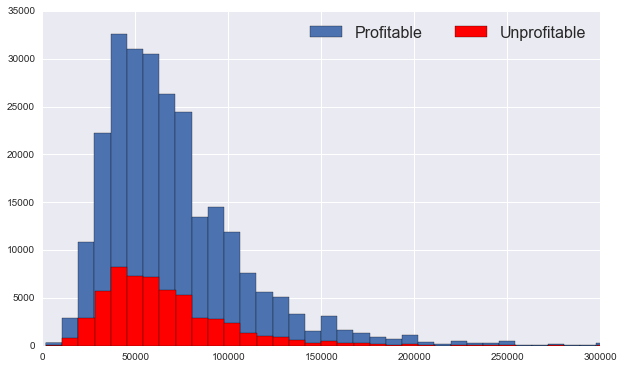

In [250]:
# Not really interesting
plt.figure(figsize=(10,6))
plt.legend(['Profitable', 'Unprofitable'], loc=1, ncol = 2, prop={'size':16})
plt.hist(data_sub.annual_inc, bins=1000)
plt.hist(data_sub.annual_inc[data_sub.binary_profit_loss_adj == 0], bins=1000, color = "red")
plt.xlim(0,300000)
plt.legend(['Profitable', 'Unprofitable'], loc=1, ncol = 2, prop={'size':16});

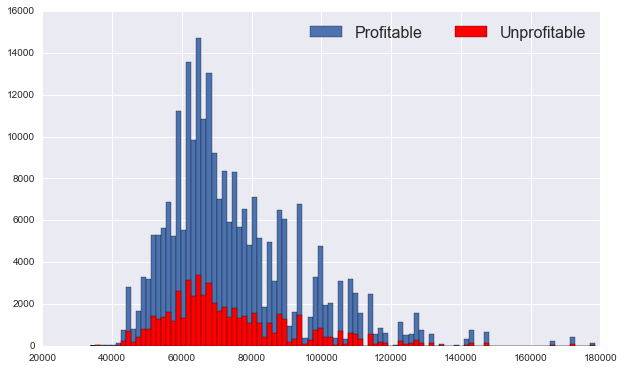

In [242]:
# Not really interesting
plt.figure(figsize=(10,6))
plt.legend(['Profitable', 'Unprofitable'], loc=1, ncol = 2, prop={'size':16})
plt.hist(data_sub.zip3_mean_income, bins=100)
plt.hist(data_sub.zip3_mean_income[data_sub.binary_profit_loss_adj == 0], bins=len(, color = "red")
plt.legend(['Profitable', 'Unprofitable'], loc=1, ncol = 2, prop={'size':16});

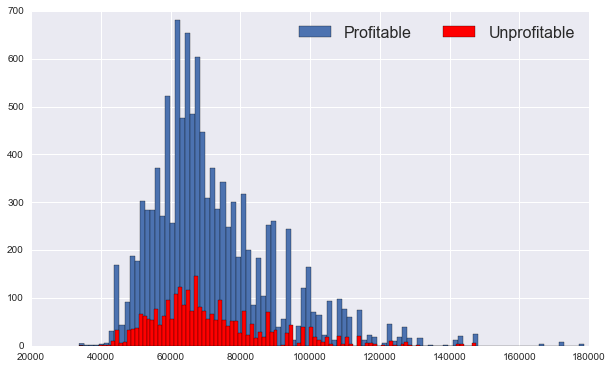

In [252]:
# NOPE
data_inc_filter = data_sub[(data_sub.annual_inc > 45000) & (data_sub.annual_inc <50000)]
plt.figure(figsize=(10,6))
plt.legend(['Profitable', 'Unprofitable'], loc=1, ncol = 2, prop={'size':16})
plt.hist(data_inc_filter.zip3_mean_income, bins=100)
plt.hist(data_inc_filter.zip3_mean_income[data_inc_filter.binary_profit_loss_adj == 0], bins=100, color = "red")
plt.legend(['Profitable', 'Unprofitable'], loc=1, ncol = 2, prop={'size':16});

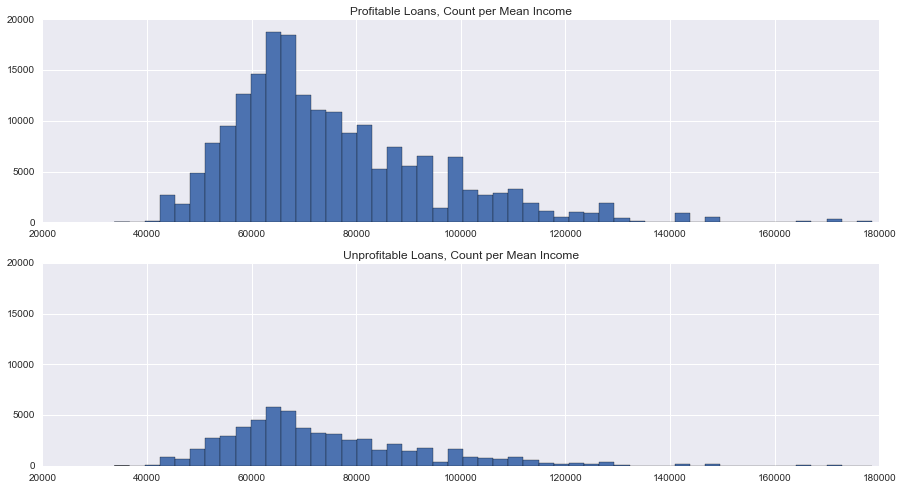

In [228]:
# Could be included...
f, (ax1, ax2) = plt.subplots(2,1, sharey=True, figsize=(15,8))

hist1 = ax1.hist(data_sub.zip3_mean_income[data_sub.binary_profit_loss_adj == 1], bins=50)
ax1.set_title('Profitable Loans, Count per Mean Income')
hist2 = ax2.hist(data_sub.zip3_mean_income[data_sub.binary_profit_loss_adj == 0], bins=50)
ax2.set_title('Unprofitable Loans, Count per Mean Income');

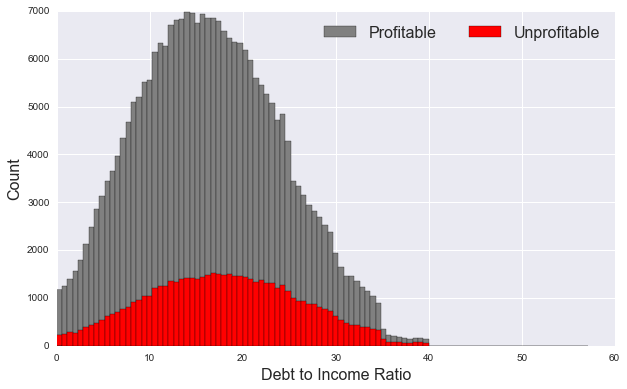

In [409]:
# Yes, included
plt.figure(figsize=(10,6))
plt.legend(['Profitable', 'Unprofitable'], loc=1, ncol = 2, prop={'size':16})
plt.hist(data_sub.dti, bins=100, color='gray')
plt.hist(data_sub.dti[data_sub.binary_profit_loss_adj == 0], bins=100, color = "red")
plt.xlabel('Debt to Income Ratio', fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.legend(['Profitable', 'Unprofitable'], loc=1, ncol = 2, prop={'size':16});

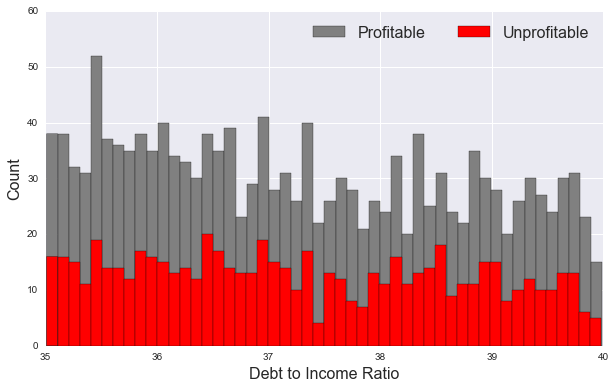

In [410]:
# Yep, include
# Zoom in of above
data_dti_filter = data_sub[(data_sub.dti > 35) & (data_sub.dti <40)]
plt.figure(figsize=(10,6))

plt.hist(data_dti_filter.dti, bins=50, color='gray')
plt.hist(data_dti_filter.dti[data_dti_filter.binary_profit_loss_adj == 0], bins=50, color = "red")
plt.xlabel('Debt to Income Ratio', fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.legend(['Profitable', 'Unprofitable'], loc=1, ncol = 2, prop={'size':16});

(0, 60000)

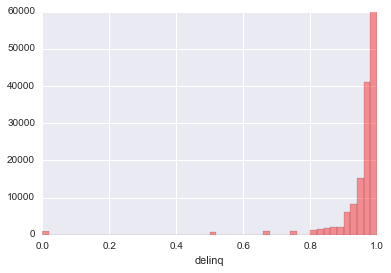

In [305]:
# Don't know what to make of this
sns.distplot(data_sub.delinq, kde=False, color='red')
plt.ylim(0,60000)

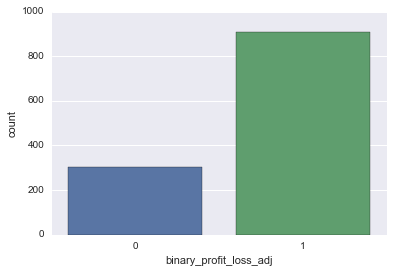

In [312]:
sns.countplot(data_sub.binary_profit_loss_adj[data_sub.delinq == .8])

In [354]:
# Brian Lucena's function to Un-Blackbox features


import numpy as np
import pandas as pd


def gen_model_pred(model, row, col_idx, values):
    rows = []
    for val in values:
        sim_row = row.copy()
        sim_row[col_idx] = val
        rows.append(sim_row)
    y_pred = model.predict_proba(rows)[:,1]
    return y_pred, values

def black_box_visualize(model, dataset, column_num, pts_selected='sample', num_pts=5, col_values='auto',
                       resolution = 100, show_base_pts=True, normalize_loc='none', **kwargs):

    ## Convert Pandas DataFrame to nparray explicitly to make life easier
    if type(dataset)==pd.DataFrame:
        dataset = dataset.values

    ## Determine which points to serve as base points depending on pts_selected and num_pts    
    if ((type(pts_selected) == str) and (pts_selected=='sample')):
        pts_chosen = np.random.choice(dataset.shape[0],np.minimum(dataset.shape[0],num_pts),replace=False)
    elif ((type(pts_selected) == str) and (pts_selected=='first')):
        pts_chosen = np.array(range(np.minimum(dataset.shape[0],num_pts)))
    else:
        pts_chosen = np.array(pts_selected)
    
    ## Determine the range of values to plot for the chosen column
    if (type(col_values)==str and col_values=='auto'):
        values_to_plot = np.linspace(np.min(dataset[:,column_num]),np.max(dataset[:,column_num]),resolution)
    else:
        values_to_plot = np.array(col_values)    
    ## Plot the lines
    _, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for row in dataset[pts_chosen,:]:
        y_pred, values = gen_model_pred(model, row, column_num, values_to_plot)
        if normalize_loc=='start':
            y_pred = y_pred - y_pred[0]
        if normalize_loc=='end':
            y_pred = y_pred - y_pred[-1]
        if (type(normalize_loc)==int and normalize_loc>=0 and normalize_loc<resolution):
            y_pred = y_pred - y_pred[normalize_loc]
        ax.plot(values, y_pred)
    if(show_base_pts and normalize_loc=='none'):
        pred_vals = model.predict_proba(dataset[pts_chosen,:])[:,1]
        ax.scatter(dataset[pts_chosen,column_num],model.predict_proba(dataset[pts_chosen,:])[:,1],**kwargs)

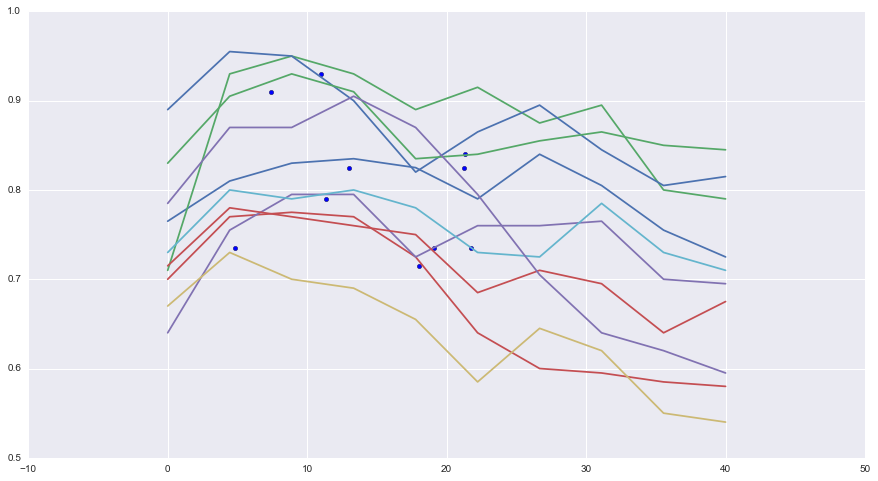

In [383]:
black_box_visualize(model_rf,X_test,column_num=np.argmax(X.columns=='dti'), num_pts=10, resolution=10)

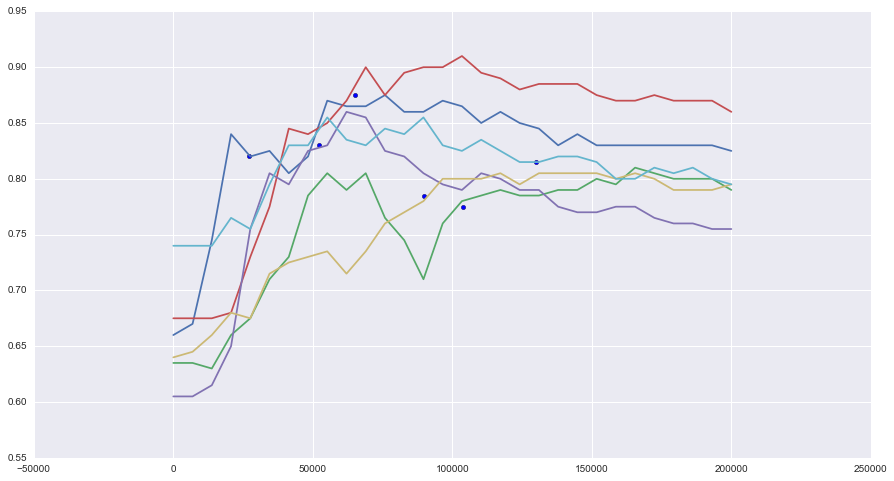

In [439]:
# Annual Income
black_box_visualize(model_rf,X_test,column_num=0,col_values=np.linspace(0,200000,30), num_pts=6, resolution = 20)

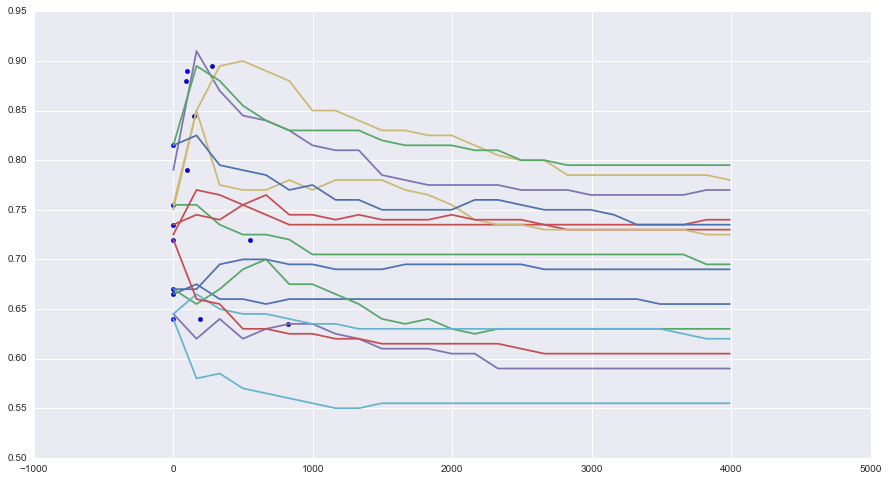

In [378]:
black_box_visualize(model_rf,X_test,column_num=np.argmax(X.columns=='desc_length'), num_pts=15, resolution = 25)

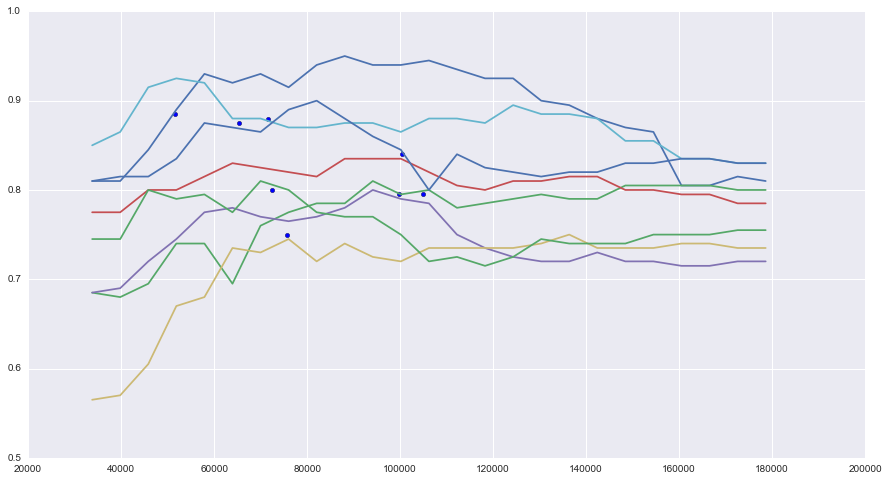

In [440]:
black_box_visualize(model_rf,X_test,column_num=np.argmax(X.columns=='zip3_mean_income'), num_pts=8, resolution = 25)

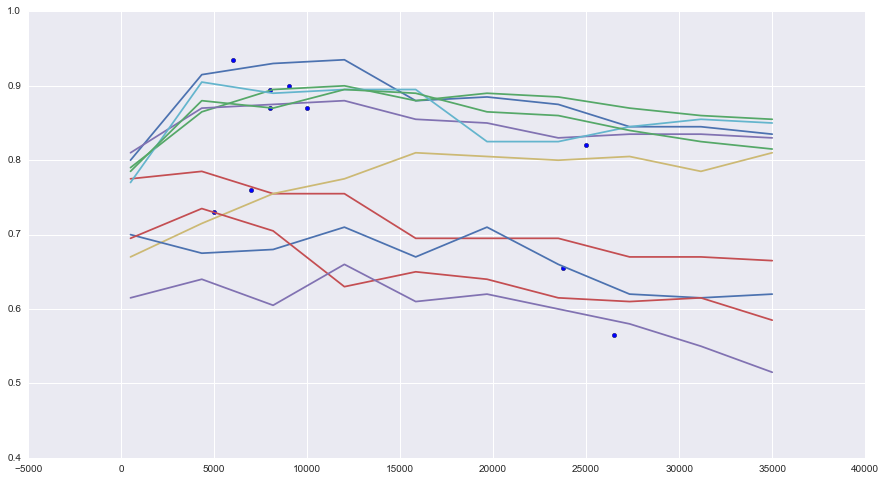

In [394]:
# The amount the loan was made for. Slightly less for larger loans, undeniably.
black_box_visualize(model_rf,X_test,column_num=np.argmax(X.columns=='funded_amnt'), num_pts=10, resolution = 10)

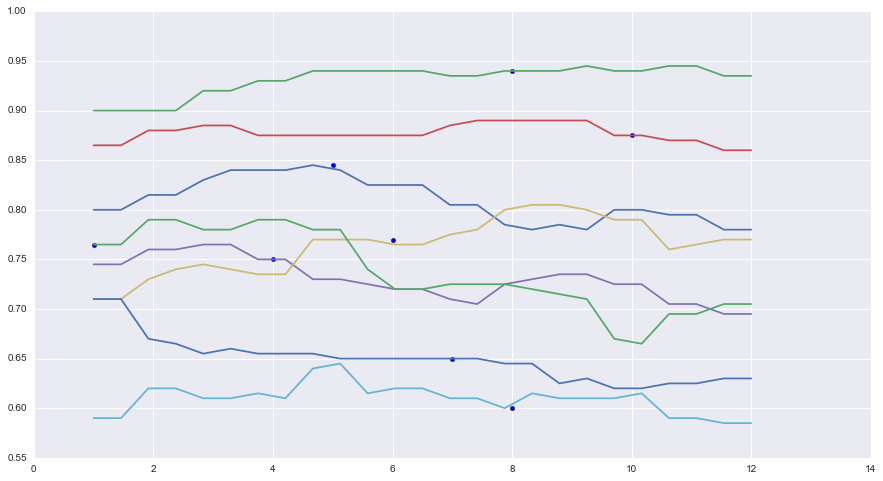

In [445]:
black_box_visualize(model_rf,X_test,column_num=np.argmax(X.columns=='issue_d_month'), num_pts=8, resolution = 25)

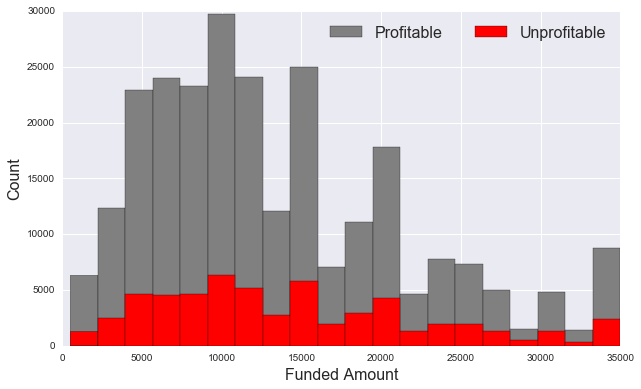

In [414]:
plt.figure(figsize=(10,6))

plt.figure(figsize=(10,6))
plt.legend(['Profitable', 'Unprofitable'], loc=1, ncol = 2, prop={'size':16})
plt.hist(data_sub.funded_amnt, bins=20, color='gray')
plt.hist(data_sub.funded_amnt[data_sub.binary_profit_loss_adj == 0], bins=20, color = "red")
plt.xlabel('Funded Amount', fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.legend(['Profitable', 'Unprofitable'], loc=1, ncol = 2, prop={'size':16});


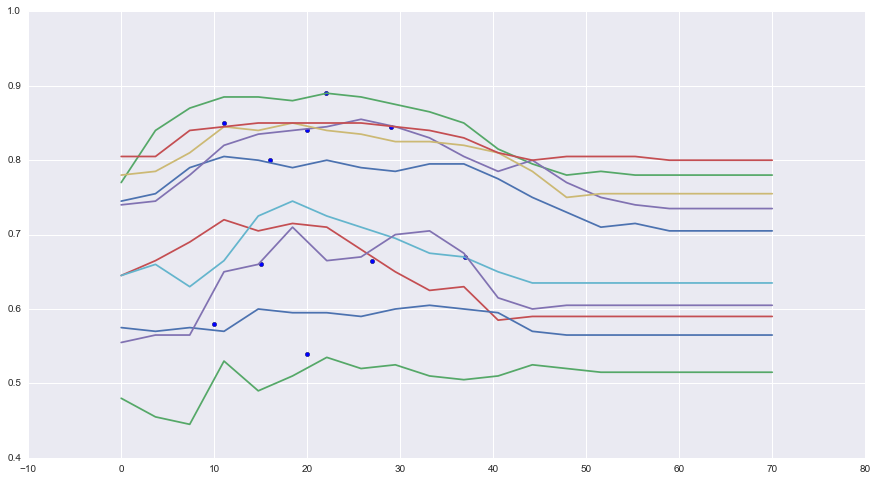

In [404]:
black_box_visualize(model_rf,X_test,column_num=np.argmax(X.columns=='pre_loan_credit_hist_length'),
                    col_values=np.linspace(0,70,20),num_pts=10)

(array([  7.80000000e+01,   1.00000000e+02,   4.81300000e+03,
          5.42800000e+03,   7.53900000e+03,   1.95230000e+04,
          1.13480000e+04,   3.22630000e+04,   1.95220000e+04,
          1.95900000e+04,   3.37970000e+04,   1.36510000e+04,
          2.30330000e+04,   9.71700000e+03,   7.89400000e+03,
          1.22060000e+04,   5.05400000e+03,   8.79300000e+03,
          3.39500000e+03,   3.03000000e+03,   4.78100000e+03,
          1.98100000e+03,   2.70900000e+03,   9.76000000e+02,
          9.07000000e+02,   1.53900000e+03,   5.66000000e+02,
          8.46000000e+02,   3.17000000e+02,   3.24000000e+02,
          4.03000000e+02,   1.30000000e+02,   2.35000000e+02,
          8.00000000e+01,   5.60000000e+01,   8.20000000e+01,
          1.80000000e+01,   3.70000000e+01,   9.00000000e+00,
          6.00000000e+00,   7.00000000e+00,   6.00000000e+00,
          5.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
        

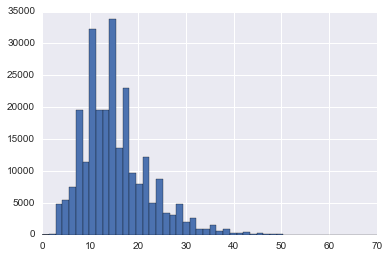

In [444]:
plt.hist(X.pre_loan_credit_hist_length,range=(0,70),bins=50)


In [211]:
pd.DataFrame(sorted(zip(X.columns,model_rf.feature_importances_), key=lambda x: x[1], reverse=True))

,0,1
0,dti,0.105739
1,zip3_mean_income,0.096541
2,annual_inc,0.094343
3,funded_amnt,0.087083
4,sub_grade_num,0.086094
5,pre_loan_credit_hist_length,0.076211
6,issue_d_month,0.067340
7,delinq,0.050987
8,emp_length_num,0.050815
9,issue_d_year,0.037504


# Tests for overfitting

Training score: [1.0, 1.0, 1.0, 1.0, 1.0]
Testing score: [0.84399999999999997, 0.82399999999999995, 0.81599999999999995, 0.82299999999999995, 0.82599999999999996]


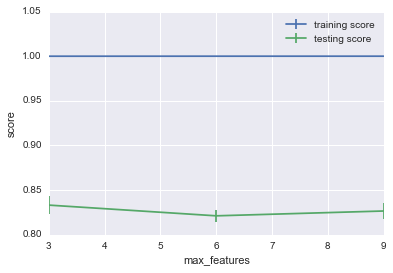

In [144]:
# Ran a bunch of these - took forever

def plot_overfit(X,y,model_obj,param_ranges,param_static=None): 
    for parameter,parameter_range in param_ranges.iteritems():
        avg_train_score, avg_test_score = [],[]
        std_train_score, std_test_score = [],[]
        
        for param_val in parameter_range:
            param = {parameter:param_val}
            if param_static:
                param.update(param_static)
                
            model = model_obj(**param)
            
            train_scores,test_scores = [],[]
            for i in range(5):
                X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .1)
                model.fit(X_train,y_train)
                
                train_scores.append(model.score(X_train,y_train))
                test_scores.append(model.score(X_test,y_test))
            
            avg_train_score.append(np.mean(train_scores))
            avg_test_score.append(np.mean(test_scores))
            
            std_train_score.append(np.std(train_scores))
            std_test_score.append(np.std(test_scores))
            
        fig,ax = plt.subplots()
        plt.figure(figsize=(12,7))
        ax.errorbar(parameter_range,avg_train_score,yerr=std_train_score,label='training score')
        ax.errorbar(parameter_range,avg_test_score,yerr=std_test_score,label='testing score')
        
        ax.set_xlabel(parameter)
        ax.set_ylabel('score')
        ax.legend(loc=0)
        print "Training score: {}".format(train_scores)
        print "Testing score: {}".format(test_scores)
model = RandomForestClassifier
params = {'max_features':[3,6,9]}
param_static = {'n_estimators':100}
plot_overfit(X,y,model,params,param_static=param_static)

# Precision Recall Curve for Model

In [386]:
def pr_curve(truthvec, scorevec, digit_prec=2):
    threshvec = np.unique(np.round(scorevec,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)

    for i in range(numthresh):
        thresh = threshvec[i]
        tpvec[i] = sum(truthvec[scorevec>=thresh])
        fpvec[i] = sum(1-truthvec[scorevec>=thresh])
        fnvec[i] = sum(truthvec[scorevec<thresh])
    recallvec = tpvec/(tpvec + fnvec)
    precisionvec = tpvec/(tpvec + fpvec)
    plt.figure(figsize=(10,6))
    plt.plot(precisionvec,recallvec, c='r')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.axis([0, 1, 0, 1])
    return (recallvec, precisionvec, threshvec)

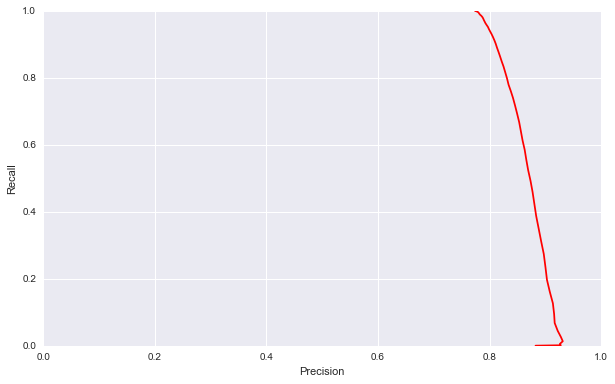

In [387]:
pr_curve(y_test, preds_probas[:,1]);


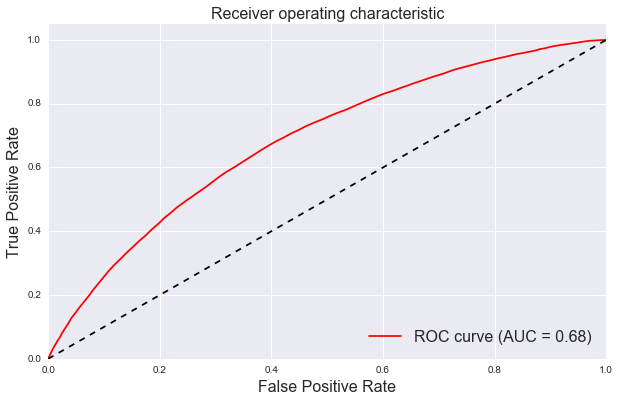

In [422]:
auc = roc_auc_score(y_test, preds_probas[:,1])
fpr, tpr, _ = roc_curve(y_test, preds_probas[:,1])
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.title('Receiver operating characteristic',fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.show()

# load pickle model

In [173]:
import pickle
#import cPickle
# ^^ Python 2
#import _pickle as cPickle
# ^^ Python 3

with open('whole_model_rf.pkl', 'rb') as fid:
    model_rf = pickle.load(fid)

In [28]:
# Confusion matrix for arbitrary threshhold 
preds_probas = model_rf.predict_proba(X_test)
raw_preds = model_rf.predict(X_test)

# do thresholding here
thresh = 0.7
thresh_preds = adjust_threshold(thresh, preds_probas[:,1])

report_default = sklearn.metrics.classification_report(y_test, raw_preds)
report_custom = sklearn.metrics.classification_report(y_test,thresh_preds)

print(report_default)
print()
print(report_custom)
print()
print(model_rf.best_estimator_)

             precision    recall  f1-score   support

          0       0.47      0.05      0.10      7075
          1       0.79      0.98      0.88     25925

avg / total       0.72      0.78      0.71     33000


             precision    recall  f1-score   support

          0       0.35      0.44      0.39      7075
          1       0.84      0.78      0.80     25925

avg / total       0.73      0.70      0.72     33000


Pipeline(steps=[('pca', PCA(copy=True, n_components=20, whiten=False)), ('feature_selection', SelectKBest(k='all', score_func=<function f_classif at 0x11632e9d8>)), ('random_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', m...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


# Sum the profit_loss of the predictions 

y_test, thresh_preds, profit_loss

In [203]:
# change later for graph readability; want granular now
thresholds = np.arange(0.1,1,0.03)

threshold_good_loans_dict = {}
threshold_bad_loans_dict = {}
sizes, ratios = [], []

# turn y_test into a dataframe
y_frame = y_test.to_frame()

# turn profit loss into a dataframe
profit_loss_frame = profit_loss.to_frame()
funded_amnt_frame = funded_amnt.to_frame()
profit_loss_rate_frame = profit_loss_rate.to_frame()

for thresh in thresholds:

    
    # add the adjusted probabilites to the data frame
    y_frame['pred'] = adjust_threshold(thresh,preds_probas[:,1])
    sizes.append([len(y_frame), len(profit_loss_frame), len(funded_amnt_frame)])
    
    # join with profit loss frame
    loan_res = y_frame.join(profit_loss_frame)
    loan_res = loan_res.join(funded_amnt_frame)
    loan_res = loan_res.join(profit_loss_rate_frame)
    
    # adds exception so it doesn't break if the probability threshold is low or high enough to be trivial
    if sum(y_frame.pred) not in [0,len(y_frame)]:

        # group by the prediction
        pred_grouped = loan_res.groupby('pred')

        # get the sum
        earning_results = pred_grouped['profit_loss' + suffix].sum()
        funded_amnts = pred_grouped['funded_amnt' + suffix].sum()
        roi_results = pred_grouped['profit_loss_rate' + suffix].mean()
        roi_weighted_results = earning_results/funded_amnts
        
        # store total earnings for loans identified as "good" by our model
        threshold_good_loans_dict[thresh] = roi_weighted_results[1]

        # store total earnings for loans identified as "bad" by our model
        # at thresholds < 0.1 the model basically goes for everything so this wont exist
        threshold_bad_loans_dict[thresh] = roi_weighted_results[0]

In [204]:
pred_grouped['profit_loss_rate' + suffix].mean()

pred
0   -0.009710
1    0.058385
Name: profit_loss_rate_adj, dtype: float64

In [205]:
from collections import OrderedDict

In [206]:
ordered_earnings_good_loans = OrderedDict(sorted(threshold_good_loans_dict.items(), key=lambda t: t[1],reverse=True))

In [207]:
import seaborn as sns

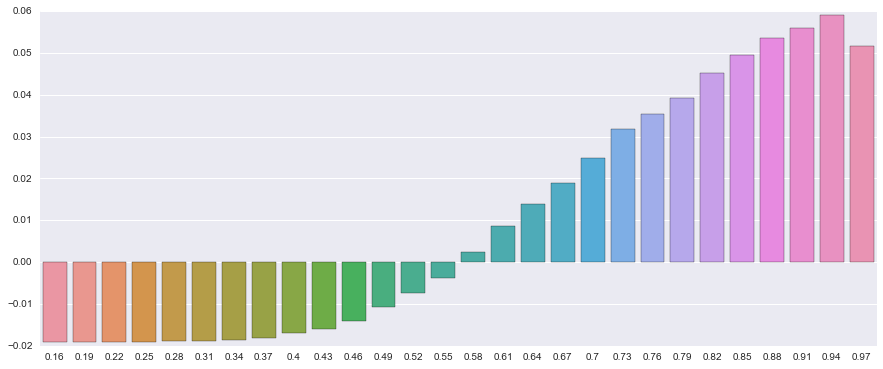

In [208]:
plt.figure(figsize=(15,6))
sns.barplot(list(threshold_good_loans_dict.keys()),list(threshold_good_loans_dict.values()));

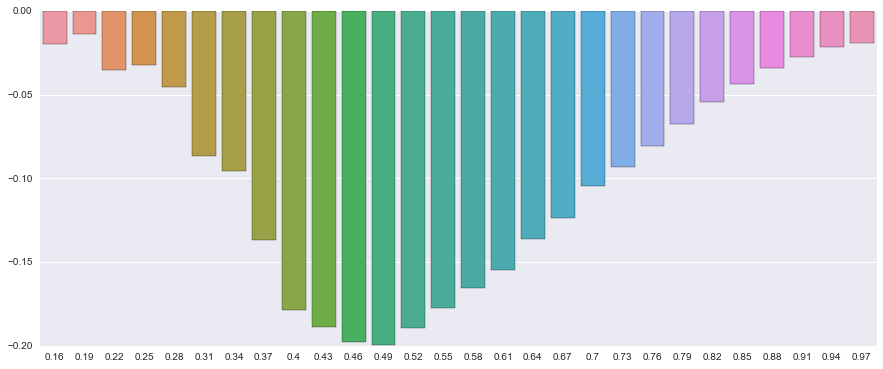

In [349]:
plt.figure(figsize=(15,6))
sns.barplot(list(threshold_bad_loans_dict.keys()),list(threshold_bad_loans_dict.values()));